# Royal Enfield Bike Price Prediction



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tabulate import tabulate

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set_style("whitegrid")

In [32]:
df = pd.read_csv("royal_enfield_data.csv")

print("\n Dataset Overview")
print("=" * 50)
print("Shape:", df.shape)
print("\nFirst 5 rows:\n", df.head())
print("\nDataset Info:")
print(df.info())


 Dataset Overview
Shape: (49, 7)

First 5 rows:
          Model  Year  Present_Price  Kms_Driven  Owner Transmission  \
0  Classic 350  2018            1.5       25000  First       Manual   
1   Bullet 350  2015            1.7       35000  First       Manual   
2    Himalayan  2019            2.2       15000  First       Manual   
3   Meteor 350  2020            2.0       10000  First       Manual   
4   Hunter 350  2021            1.8        8000  First       Manual   

   Selling_Price  
0           1.20  
1           1.30  
2           1.90  
3           1.75  
4           1.60  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Model          49 non-null     object 
 1   Year           49 non-null     int64  
 2   Present_Price  49 non-null     float64
 3   Kms_Driven     49 non-null     int64  
 4   Owner          49 non-n

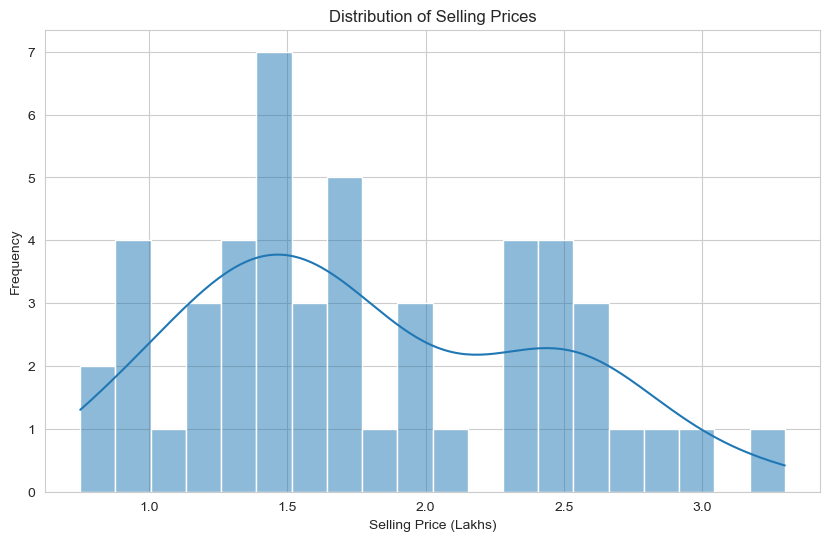

In [6]:
# Distribution of selling prices
plt.figure(figsize=(10, 6))
sns.histplot(df['Selling_Price'], bins=20, kde=True)
plt.title('Distribution of Selling Prices')
plt.xlabel('Selling Price (Lakhs)')
plt.ylabel('Frequency')
plt.show()

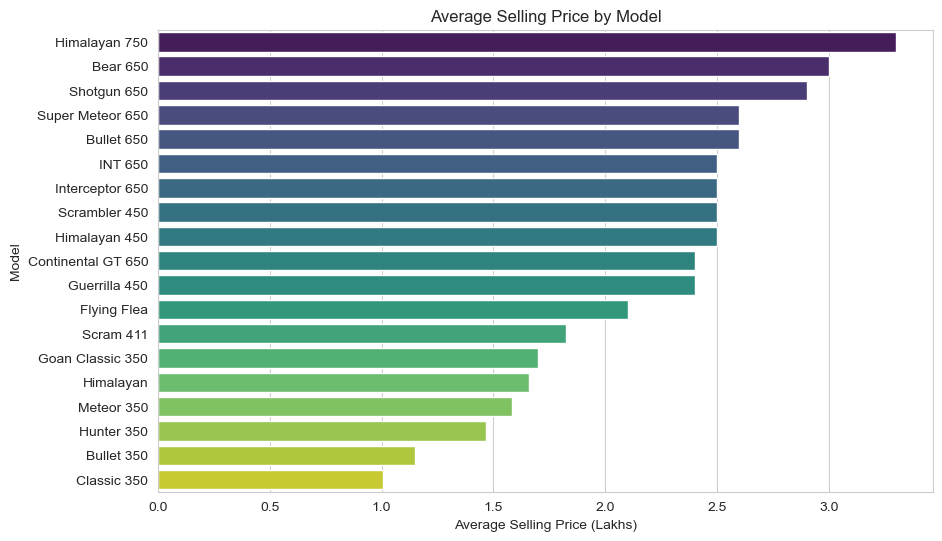

In [7]:
# Average selling price by model
plt.figure(figsize=(10, 6))
model_prices = df.groupby('Model')['Selling_Price'].mean().sort_values(ascending=False)
sns.barplot(x=model_prices.values, y=model_prices.index, palette='viridis')
plt.title('Average Selling Price by Model')
plt.xlabel('Average Selling Price (Lakhs)')
plt.ylabel('Model')
plt.show()

## 3. Feature Engineering

In [34]:
current_year = 2023
df["Bike_Age"] = current_year - df["Year"]

# Label encoding
le_model = LabelEncoder()
le_owner = LabelEncoder()
le_transmission = LabelEncoder()

df["Model_encoded"] = le_model.fit_transform(df["Model"])
df["Owner_encoded"] = le_owner.fit_transform(df["Owner"])
df["Transmission_encoded"] = le_transmission.fit_transform(df["Transmission"])

features = ["Model_encoded", "Bike_Age", "Kms_Driven", "Owner_encoded", "Transmission_encoded", "Present_Price"]
X = df[features]
y = df["Selling_Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n Training Samples:", X_train.shape[0])
print(" Testing Samples :", X_test.shape[0])


 Training Samples: 39
 Testing Samples : 10


In [36]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
}

results = []

def evaluate_model(name, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results.append([name, r2, rmse, mae, model])
    return r2

print("\n Training Models...")
for name, model in models.items():
    evaluate_model(name, model)


 Training Models...


In [38]:
# Show summary
results_df = pd.DataFrame(results, columns=["Model", "R²", "RMSE", "MAE", "Object"])
print("\n Model Performance")
print(tabulate(results_df.drop("Object", axis=1), headers="keys", tablefmt="fancy_grid", showindex=False))


 Model Performance
╒═══════════════════╤══════════╤═══════════╤═══════════╕
│ Model             │       R² │      RMSE │       MAE │
╞═══════════════════╪══════════╪═══════════╪═══════════╡
│ Linear Regression │ 0.991211 │ 0.0740205 │ 0.0633848 │
├───────────────────┼──────────┼───────────┼───────────┤
│ Random Forest     │ 0.949578 │ 0.177293  │ 0.144625  │
├───────────────────┼──────────┼───────────┼───────────┤
│ Gradient Boosting │ 0.965776 │ 0.146066  │ 0.123774  │
╘═══════════════════╧══════════╧═══════════╧═══════════╛


In [40]:
best_row = results_df.iloc[results_df["R²"].idxmax()]
best_model, best_name = best_row["Object"], best_row["Model"]

print(f"\n Best Model: {best_name} (R² = {best_row['R²']:.4f})")

# Save model + encoders
joblib.dump(best_model, "royal_enfield_model.pkl")
joblib.dump(le_model, "le_model.pkl")
joblib.dump(le_owner, "le_owner.pkl")
joblib.dump(le_transmission, "le_transmission.pkl")

print(" Model & Encoders Saved!")


 Best Model: Linear Regression (R² = 0.9912)
 Model & Encoders Saved!


In [42]:
if hasattr(best_model, "feature_importances_"):
    importance = pd.DataFrame({
        "Feature": features,
        "Importance": best_model.feature_importances_
    }).sort_values("Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Feature Importance - {best_name}")
    plt.tight_layout()
    plt.show()

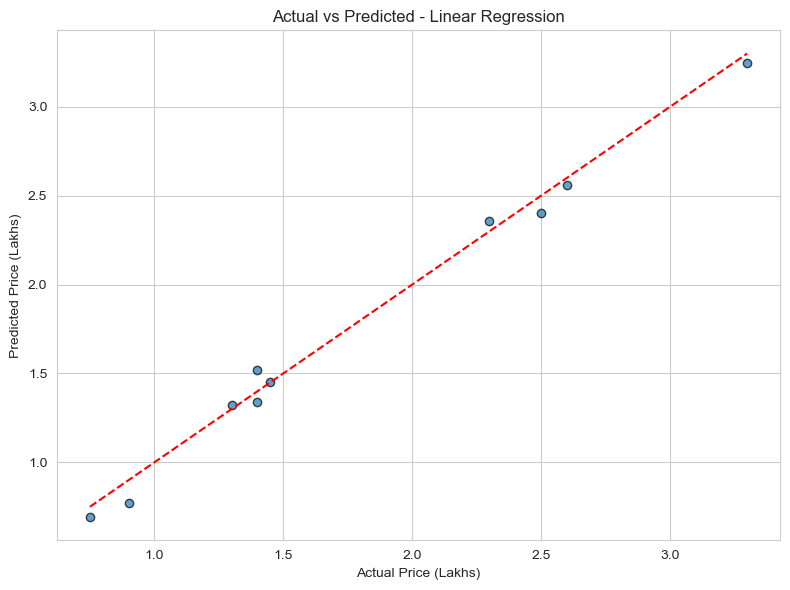

In [18]:
plt.figure(figsize=(8, 6))
y_pred_best = best_model.predict(X_test)
plt.scatter(y_test, y_pred_best, alpha=0.7, edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Actual Price (Lakhs)")
plt.ylabel("Predicted Price (Lakhs)")
plt.title(f"Actual vs Predicted - {best_name}")
plt.tight_layout()
plt.show()